In [1]:
from sympy import *
from sympy.vector import CoordSys3D, Del
from sympy.simplify.epathtools import EPath

# this is for all the trigonometric simplifications
from sympy.simplify.fu import *

In [2]:
R = CoordSys3D('R')
delop = Del()
x = R.x
y = R.y

eps, theta, r = symbols('epsilon theta r')
nx = Function('n_x')(x, y)
ny = Function('n_y')(x, y)

In [3]:
n = nx * R.i + ny * R.j
n

(n_x(R.x, R.y))*R.i + (n_y(R.x, R.y))*R.j

In [4]:
A, B = symbols('A B')

### Calculate charge density

Splay is $\frac12 K_1 (\nabla \cdot \mathbf{n})^2$

Bend is $\frac12 K_3 |\mathbf{n} \times (\nabla \times \mathbf{n})|^2$

In Carter parlance, $\epsilon = \frac{K_1 - K_3}{K_1 + K_3}$ which differs by a sign from Cody parlance.

Hence, taking $K = \frac{K_1 + K_3}{2}$ we get that $K_1 = 2 K \epsilon + K_3$ and $K_3 = -2 K \epsilon + K_1$

This simplifies to: $K_1 = K (1 + \epsilon)$ and $K_3 = K (1 - \epsilon)$

In [5]:
splay = simplify( delop.dot(n).doit()**2 )
splay

(Derivative(n_x(R.x, R.y), R.x) + Derivative(n_y(R.x, R.y), R.y))**2

In [6]:
bend = simplify( n.cross( delop.cross(n).doit() ).magnitude()**2 )
bend = bend.subs(nx**2 + ny**2, 1)
bend

(Derivative(n_x(R.x, R.y), R.y) - Derivative(n_y(R.x, R.y), R.x))**2

Hence, the nondimensional energy density for the director is:

In [7]:
g = (1 + eps) * splay + (1 - eps) * bend
g

(1 - epsilon)*(Derivative(n_x(R.x, R.y), R.y) - Derivative(n_y(R.x, R.y), R.x))**2 + (epsilon + 1)*(Derivative(n_x(R.x, R.y), R.x) + Derivative(n_y(R.x, R.y), R.y))**2

### Calculate in terms of director angle

In [8]:
phi = Function('phi')(x, y)
phi

phi(R.x, R.y)

In [9]:
g = simplify( g.subs({nx: cos(phi), ny: sin(phi)}) )
g

(1 - epsilon)*(sin(phi(R.x, R.y))*Derivative(phi(R.x, R.y), R.y) + cos(phi(R.x, R.y))*Derivative(phi(R.x, R.y), R.x))**2 + (epsilon + 1)*(-sin(phi(R.x, R.y))*Derivative(phi(R.x, R.y), R.x) + cos(phi(R.x, R.y))*Derivative(phi(R.x, R.y), R.y))**2

### Change to [polar coordinates](https://www.wikiwand.com/en/Polar_coordinate_system#Differential_calculus)

In [10]:
phi_p = Function('phi')(theta)

In [11]:
dphi_dx = cos(theta) * phi_p.diff(r) - (1/r) * sin(theta) * phi_p.diff(theta)
dphi_dy = sin(theta) * phi_p.diff(r) + (1/r) * cos(theta) * phi_p.diff(theta)

In [12]:
g_polar = g.subs({phi.diff(x) : dphi_dx, phi.diff(y) : dphi_dy, phi : phi_p})
g_polar = simplify(g_polar)
display(g_polar)

((1 - epsilon)*sin(theta - phi(theta))**2 + (epsilon + 1)*cos(theta - phi(theta))**2)*Derivative(phi(theta), theta)**2/r**2

To make look like Carter's (8), we turn sines to cosines, lower power of sines

In [13]:
g_polar = simplify(TR7(TR5(g_polar)))
display(g_polar)

(epsilon*cos(2*theta - 2*phi(theta)) + 1)*Derivative(phi(theta), theta)**2/r**2

### Plug it into [Euler-Lagrange equation](https://www.wikiwand.com/en/Euler%E2%80%93Lagrange_equation#Single_function_of_several_variables_with_single_derivative)

To get Carter's (9) we plug into Euler-Lagrange in polar

In [14]:
euler_lagrange = simplify(g_polar.diff(phi_p) - g_polar.diff(phi_p.diff(theta)).diff(theta))
euler_lagrange = trigsimp(factor(euler_lagrange, eps))
euler_lagrange = simplify(euler_lagrange * -Rational(1, 2) * r**2)
euler_lagrange = factor(euler_lagrange, eps, phi_p.diff(theta, 2), sin(2*theta - 2*phi_p))
display(euler_lagrange)

epsilon*(Derivative(phi(theta), theta)**2 - 2*Derivative(phi(theta), theta))*sin(2*theta - 2*phi(theta)) + epsilon*cos(2*theta - 2*phi(theta))*Derivative(phi(theta), (theta, 2)) + Derivative(phi(theta), (theta, 2))

### Assume ansatz

In [15]:
q, C = symbols('q C')
ansatz = q * theta + eps * C * sin(2 * (1 - q) * theta)

In [16]:
ansatz_euler_lagrange = simplify(euler_lagrange.subs(phi_p, ansatz))
ansatz_euler_lagrange = expand(ansatz_euler_lagrange).subs({eps**2: 0, eps**3: 0})
display(ansatz_euler_lagrange)

4*C*epsilon*q**2*sin(2*q*theta - 2*theta) - 8*C*epsilon*q*sin(2*q*theta - 2*theta) + 4*C*epsilon*sin(2*q*theta - 2*theta) + epsilon*q**2*sin(2*C*epsilon*sin(2*q*theta - 2*theta) - 2*q*theta + 2*theta) - 2*epsilon*q*sin(2*C*epsilon*sin(2*q*theta - 2*theta) - 2*q*theta + 2*theta)

Need to, by eye, deal with $\epsilon \sin$ terms whose arguments contain $\epsilon \sin$

Angle addition formula: $\sin(a + b) = \sin(a)\cos(b) + \sin(b)\cos(a)$

In [17]:
sin_subs = {sin(2*C*eps*sin(2*q*theta - 2*theta)
                - 2*q*theta 
                + 2*theta):
                sin(2*C*eps*sin(2*q*theta - 2*theta))
                * cos(2*theta - 2*q*theta)
                +
                sin(2*theta - 2*q*theta)
                * cos(2*C*eps*sin(2*q*theta - 2*theta))}

ansatz_euler_lagrange = ansatz_euler_lagrange.subs(sin_subs)
display(ansatz_euler_lagrange)

4*C*epsilon*q**2*sin(2*q*theta - 2*theta) - 8*C*epsilon*q*sin(2*q*theta - 2*theta) + 4*C*epsilon*sin(2*q*theta - 2*theta) + epsilon*q**2*(sin(2*C*epsilon*sin(2*q*theta - 2*theta))*cos(2*q*theta - 2*theta) - sin(2*q*theta - 2*theta)*cos(2*C*epsilon*sin(2*q*theta - 2*theta))) - 2*epsilon*q*(sin(2*C*epsilon*sin(2*q*theta - 2*theta))*cos(2*q*theta - 2*theta) - sin(2*q*theta - 2*theta)*cos(2*C*epsilon*sin(2*q*theta - 2*theta)))

Small angle approximation:

In [18]:
trig_subs = {sin(2*C*eps*sin(2*q*theta - 2*theta)):
             2*C*eps*sin(2*q*theta - 2*theta),
             cos(2*C*eps*sin(2*q*theta - 2*theta)):
             1}
                 
ansatz_euler_lagrange = expand(ansatz_euler_lagrange.subs(trig_subs))
ansatz_euler_lagrange = ansatz_euler_lagrange.subs(eps**2, 0)
display(ansatz_euler_lagrange)

4*C*epsilon*q**2*sin(2*q*theta - 2*theta) - 8*C*epsilon*q*sin(2*q*theta - 2*theta) + 4*C*epsilon*sin(2*q*theta - 2*theta) - epsilon*q**2*sin(2*q*theta - 2*theta) + 2*epsilon*q*sin(2*q*theta - 2*theta)

In [19]:
sol = solve(ansatz_euler_lagrange, C)
display(sol[0])

q*(q - 2)/(4*(q**2 - 2*q + 1))

In [20]:
single_defect_approximation = ansatz.subs(C, sol[0])
display(single_defect_approximation)

epsilon*q*(q - 2)*sin(theta*(2 - 2*q))/(4*(q**2 - 2*q + 1)) + q*theta

### Above is the first-order approximation to a single defect under the Dzyaloshinskii solution

$q = 1/2$

In [21]:
display(simplify(single_defect_approximation.subs(q, Rational(1, 2))))

-3*epsilon*sin(theta)/4 + theta/2

$q = -1/2$

In [22]:
display(simplify(single_defect_approximation.subs(q, -Rational(1, 2))))

5*epsilon*sin(3*theta)/36 - theta/2

## Two-defect approximation

### First, Euler Lagrange in cartesian coordinates

In [23]:
euler_lagrange = -simplify(g.diff(phi) 
                           - (g.diff(phi.diff(x)).diff(x) 
                              + g.diff(phi.diff(y)).diff(y))) / 2

euler_lagrange = factor(euler_lagrange, phi.diff(x, 2), phi.diff(y, 2))

euler_lagrange = trigsimp(euler_lagrange)
euler_lagrange = simplify(euler_lagrange)

# sines to cosines, lower degree of cosines
euler_lagrange = simplify(TR7(TR5(euler_lagrange)))

# factor out trig functions
euler_lagrange = factor(euler_lagrange, sin(2*phi), cos(2*phi), eps)

display(euler_lagrange)

epsilon*(-2*Derivative(phi(R.x, R.y), R.x)*Derivative(phi(R.x, R.y), R.y) - Derivative(phi(R.x, R.y), (R.x, 2)) + Derivative(phi(R.x, R.y), (R.y, 2)))*cos(2*phi(R.x, R.y)) + epsilon*(Derivative(phi(R.x, R.y), R.x)**2 - Derivative(phi(R.x, R.y), R.y)**2 - 2*Derivative(phi(R.x, R.y), R.x, R.y))*sin(2*phi(R.x, R.y)) + Derivative(phi(R.x, R.y), (R.x, 2)) + Derivative(phi(R.x, R.y), (R.y, 2))

c.f. above with Carter's (16)

### Now we need to substitute the Ansatz

In [24]:
phi_c = Function('phi_c')(x, y)
theta_1 = Function('theta_1')(x, y)
theta_2 = Function('theta_2')(x, y)
r_1 = Function('r_1')(x, y)
r_2 = Function('r_2')(x, y)

q1, q2 = symbols('q_1 q_2')

ansatz = q1 * theta_1 + q2 * theta_2 + eps * phi_c
display(ansatz)

epsilon*phi_c(R.x, R.y) + q_1*theta_1(R.x, R.y) + q_2*theta_2(R.x, R.y)

In [25]:
euler_lagrange_p = euler_lagrange.subs(phi, ansatz)
euler_lagrange_p = simplify(euler_lagrange_p.doit())
display(euler_lagrange_p)

-epsilon*(2*epsilon*Derivative(phi_c(R.x, R.y), R.x, R.y) + 2*q_1*Derivative(theta_1(R.x, R.y), R.x, R.y) + 2*q_2*Derivative(theta_2(R.x, R.y), R.x, R.y) - (epsilon*Derivative(phi_c(R.x, R.y), R.x) + q_1*Derivative(theta_1(R.x, R.y), R.x) + q_2*Derivative(theta_2(R.x, R.y), R.x))**2 + (epsilon*Derivative(phi_c(R.x, R.y), R.y) + q_1*Derivative(theta_1(R.x, R.y), R.y) + q_2*Derivative(theta_2(R.x, R.y), R.y))**2)*sin(2*epsilon*phi_c(R.x, R.y) + 2*q_1*theta_1(R.x, R.y) + 2*q_2*theta_2(R.x, R.y)) - epsilon*(epsilon*Derivative(phi_c(R.x, R.y), (R.x, 2)) - epsilon*Derivative(phi_c(R.x, R.y), (R.y, 2)) + q_1*Derivative(theta_1(R.x, R.y), (R.x, 2)) - q_1*Derivative(theta_1(R.x, R.y), (R.y, 2)) + q_2*Derivative(theta_2(R.x, R.y), (R.x, 2)) - q_2*Derivative(theta_2(R.x, R.y), (R.y, 2)) + 2*(epsilon*Derivative(phi_c(R.x, R.y), R.x) + q_1*Derivative(theta_1(R.x, R.y), R.x) + q_2*Derivative(theta_2(R.x, R.y), R.x))*(epsilon*Derivative(phi_c(R.x, R.y), R.y) + q_1*Derivative(theta_1(R.x, R.y), R.y) +

Use [Polar Coordinates](https://www.wikiwand.com/en/Polar_coordinate_system#/Differential_calculus) again

In [26]:
euler_lagrange_p = euler_lagrange_p.subs({theta_1.diff(x): -1/r_1 * sin(theta_1),
                                          theta_2.diff(x): -1/r_2 * sin(theta_2),
                                          theta_1.diff(y): 1/r_1 * cos(theta_1),
                                          theta_2.diff(y): 1/r_2 * cos(theta_2)})

euler_lagrange_p = euler_lagrange_p.doit()

euler_lagrange_p = euler_lagrange_p.subs({theta_1.diff(x): -1/r_1 * sin(theta_1),
                                          theta_2.diff(x): -1/r_2 * sin(theta_2),
                                          theta_1.diff(y): 1/r_1 * cos(theta_1),
                                          theta_2.diff(y): 1/r_2 * cos(theta_2)})

euler_lagrange_p = euler_lagrange_p.subs({r_1.diff(x): cos(theta_1),
                                          r_2.diff(x): cos(theta_2),
                                          r_1.diff(y): sin(theta_1),
                                          r_2.diff(y): sin(theta_2)})

euler_lagrange_p = simplify(euler_lagrange_p)

display(euler_lagrange_p)

epsilon*((Derivative(phi_c(R.x, R.y), (R.x, 2)) + Derivative(phi_c(R.x, R.y), (R.y, 2)))*r_1(R.x, R.y)**2*r_2(R.x, R.y)**2 - (epsilon*(Derivative(phi_c(R.x, R.y), (R.x, 2)) - Derivative(phi_c(R.x, R.y), (R.y, 2)))*r_1(R.x, R.y)**2*r_2(R.x, R.y)**2 + 2*q_1*r_2(R.x, R.y)**2*sin(2*theta_1(R.x, R.y)) + 2*q_2*r_1(R.x, R.y)**2*sin(2*theta_2(R.x, R.y)) - 2*(-epsilon*r_1(R.x, R.y)*r_2(R.x, R.y)*Derivative(phi_c(R.x, R.y), R.x) + q_1*r_2(R.x, R.y)*sin(theta_1(R.x, R.y)) + q_2*r_1(R.x, R.y)*sin(theta_2(R.x, R.y)))*(epsilon*r_1(R.x, R.y)*r_2(R.x, R.y)*Derivative(phi_c(R.x, R.y), R.y) + q_1*r_2(R.x, R.y)*cos(theta_1(R.x, R.y)) + q_2*r_1(R.x, R.y)*cos(theta_2(R.x, R.y))))*cos(2*epsilon*phi_c(R.x, R.y) + 2*q_1*theta_1(R.x, R.y) + 2*q_2*theta_2(R.x, R.y)) - (2*epsilon*r_1(R.x, R.y)**2*r_2(R.x, R.y)**2*Derivative(phi_c(R.x, R.y), R.x, R.y) - 2*q_1*r_2(R.x, R.y)**2*cos(2*theta_1(R.x, R.y)) - 2*q_2*r_1(R.x, R.y)**2*cos(2*theta_2(R.x, R.y)) - (-epsilon*r_1(R.x, R.y)*r_2(R.x, R.y)*Derivative(phi_c(R.x, R.

In [27]:
euler_lagrange_p = expand(euler_lagrange_p)
euler_lagrange_p = euler_lagrange_p.subs({eps**2 : 0, eps**3 : 0})
euler_lagrange_p = simplify(euler_lagrange_p)

euler_lagrange_p = simplify(expand(euler_lagrange_p))
display(euler_lagrange_p)

epsilon*(-2*q_1*q_2*r_1(R.x, R.y)*r_2(R.x, R.y)*sin(2*epsilon*phi_c(R.x, R.y) + 2*q_1*theta_1(R.x, R.y) + 2*q_2*theta_2(R.x, R.y) - theta_1(R.x, R.y) - theta_2(R.x, R.y)) + q_1*(2 - q_1)*r_2(R.x, R.y)**2*sin(2*epsilon*phi_c(R.x, R.y) + 2*q_1*theta_1(R.x, R.y) + 2*q_2*theta_2(R.x, R.y) - 2*theta_1(R.x, R.y)) + q_2*(2 - q_2)*r_1(R.x, R.y)**2*sin(2*epsilon*phi_c(R.x, R.y) + 2*q_1*theta_1(R.x, R.y) + 2*q_2*theta_2(R.x, R.y) - 2*theta_2(R.x, R.y)) + (Derivative(phi_c(R.x, R.y), (R.x, 2)) + Derivative(phi_c(R.x, R.y), (R.y, 2)))*r_1(R.x, R.y)**2*r_2(R.x, R.y)**2)/(r_1(R.x, R.y)**2*r_2(R.x, R.y)**2)

Hard to manipulate arguments of trig functions in sympy, but c.f. Carter's (18)

## Great, now that we've got the governing equation let's solve

In [28]:
q1, q2, eps = symbols('q_1 q_2 epsilon')
theta1, theta2, theta = symbols('theta_1 theta_2 theta')
r1, r2, r, d = symbols('r_1 r_2 r d', positive=True)

In [29]:
eq_rhs = ( (q1*(2 - q1)*eps / r1**2) * sin(2*(1 - q1)*theta1 - 2*q2*theta2)
           + (q2*(2 - q2)*eps / r2**2) * sin(2*(1 - q2)*theta2 - 2*q1*theta1)
           - (2*eps*q1*q2 / (r1*r2)) * sin((1 - 2*q1)*theta1 + (1 - 2*q2)*theta2) )
display(eq_rhs)

-2*epsilon*q_1*q_2*sin(theta_1*(1 - 2*q_1) + theta_2*(1 - 2*q_2))/(r_1*r_2) - epsilon*q_1*(2 - q_1)*sin(2*q_2*theta_2 - theta_1*(2 - 2*q_1))/r_1**2 - epsilon*q_2*(2 - q_2)*sin(2*q_1*theta_1 - theta_2*(2 - 2*q_2))/r_2**2

In [30]:
# angle addition formula so we can use approximations in different cases
eq_rhs = TR10(eq_rhs)
display(eq_rhs)

-2*epsilon*q_1*q_2*(sin(theta_1*(1 - 2*q_1))*cos(theta_2*(1 - 2*q_2)) + sin(theta_2*(1 - 2*q_2))*cos(theta_1*(1 - 2*q_1)))/(r_1*r_2) - epsilon*q_1*(2 - q_1)*(sin(2*q_2*theta_2)*cos(theta_1*(2 - 2*q_1)) - sin(theta_1*(2 - 2*q_1))*cos(2*q_2*theta_2))/r_1**2 - epsilon*q_2*(2 - q_2)*(sin(2*q_1*theta_1)*cos(theta_2*(2 - 2*q_2)) - sin(theta_2*(2 - 2*q_2))*cos(2*q_1*theta_1))/r_2**2

# Far from both defects approximations

In [31]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

In [32]:
plt.style.use('science')
mpl.rcParams['figure.dpi'] = 200

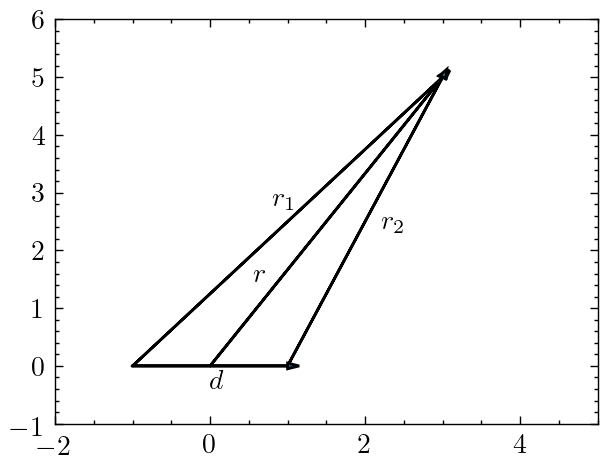

In [33]:
rp = np.array([3, 5])
dp = np.array([2, 0])
r1p = rp + dp/2
r2p = rp - dp/2

deltap = np.array([0.2, 0.2])

plt.arrow(-dp[0]/2, -dp[1]/2, r1p[0], r1p[1], head_width=0.1)
plt.text(r1p[0]/2 - dp[0]/2 - deltap[0], r1p[1]/2 - dp[1]/2 + deltap[1], r'$r_1$')

plt.arrow(0, 0, rp[0], rp[1], head_width=0.1)
plt.text(rp[0]/4 - deltap[0], rp[1]/4 + deltap[1], r'$r$')

plt.arrow(dp[0]/2, dp[1]/2, r2p[0], r2p[1], head_width=0.1)
plt.text(r2p[0]/2 + dp[0]/2 + deltap[0], r2p[1] / 2 + dp[1]/2 - deltap[0], r'$r_2$')

plt.arrow(-dp[0]/2, -dp[1], dp[0], dp[1], head_width=0.1)
plt.text(0, - 2*deltap[1], r'$d$')


plt.xlim([-2, 5])
plt.ylim([-1, 6])
plt.show()

$\mathbf{r}_2 + \frac{\mathbf{d}}{2} = \mathbf{r} \implies \mathbf{r}_2 = \mathbf{r} - \frac{\mathbf{d}}{2}$

$\mathbf{r}_1 - \frac{\mathbf{d}}{2} = \mathbf{r} \implies \mathbf{r}_1 = \mathbf{r} + \frac{\mathbf{d}}{2}$

$(\mathbf{r} \pm \frac{\mathbf{d}}{2})^2 = r^2 + \frac{d^2}{4} \pm rd \cos\theta$

$r_2 = \sqrt{r^2 + \frac{d^2}{4} - rd\cos\theta}$

$r_1 = \sqrt{r^2 + \frac{d^2}{4} + rd\cos\theta}$

$\mathbf{r_2} \cdot \mathbf{d} = r_2 d \cos\theta_2 = rd \cos\theta - \frac{d^2}{2} \implies \cos\theta_2 = \frac{r\cos\theta - \frac{d}{2}}{\sqrt{r^2 + \frac{d^2}{4} - rd\cos\theta}}$

$\mathbf{r_1} \cdot \mathbf{d} = r_1 d \cos\theta_1 = rd\cos\theta + \frac{d^2}{2} \implies \cos\theta_1 = \frac{r\cos\theta + \frac{d}{2}}{\sqrt{r^2 + \frac{d^2}{4} + rd\cos\theta}}$

$|\mathbf{r_2}\times \mathbf{d}| = r_2 d \sin\theta_2 = rd\sin\theta \implies \sin\theta_2 = \frac{r\sin\theta}{\sqrt{r^2 + \frac{d^2}{4} - rd\cos\theta}}$

$|\mathbf{r_1}\times \mathbf{d}| = r_1 d \sin\theta_1 = rd\sin\theta \implies \sin\theta_1 = \frac{r\sin\theta}{\sqrt{r^2 + \frac{d^2}{4} + rd\cos\theta}}$

### Write substitution dictionaries corresponding to the angle and radial substitutions

In [34]:
theta_subs_dict = {sin(theta1): (r * sin(theta) / r1),
                   sin(theta2): r * sin(theta) / r2,
                   cos(theta1): (r * cos(theta) + d/2) / r1,
                   cos(theta2): (r * cos(theta) - d/2) / r2}

r_subs_dict = {r1: sqrt(r**2 + d**2 / 4 + r*d*cos(theta)),
               r2: sqrt(r**2 + d**2 / 4 - r*d*cos(theta))}

triple_angle_theta1 = {sin(3*theta1): 3*sin(theta1) - 4*sin(theta1)**3,
                       cos(3*theta1): 4*cos(theta1)**3 - 3*cos(theta1)}

triple_angle_theta2 = {sin(3*theta2): 3*sin(theta2) - 4*sin(theta2)**3,
                       cos(3*theta2): 4*cos(theta2)**3 - 3*cos(theta2)}

## Choose $q_1 = +1/2$ and $q_2 = -1/2$

In [35]:
eq_rhs_pos = eq_rhs.subs({q1: Rational(1, 2), q2: -Rational(1, 2)})
display(eq_rhs_pos)

5*epsilon*(sin(theta_1)*cos(3*theta_2) - sin(3*theta_2)*cos(theta_1))/(4*r_2**2) + epsilon*sin(2*theta_2)/(2*r_1*r_2) - 3*epsilon*(-sin(theta_1)*cos(theta_2) - sin(theta_2)*cos(theta_1))/(4*r_1**2)

Use [Triple angle identities](https://brilliant.org/wiki/triple-angle-identities/)

In [36]:
eq_rhs_pos = TR11(eq_rhs_pos) #double angle
eq_rhs_pos = eq_rhs_pos.subs(triple_angle_theta2) # triple angle
eq_rhs_pos = expand(eq_rhs_pos)
display(eq_rhs_pos)

5*epsilon*sin(theta_1)*cos(theta_2)**3/r_2**2 - 15*epsilon*sin(theta_1)*cos(theta_2)/(4*r_2**2) + 5*epsilon*sin(theta_2)**3*cos(theta_1)/r_2**2 - 15*epsilon*sin(theta_2)*cos(theta_1)/(4*r_2**2) + epsilon*sin(theta_2)*cos(theta_2)/(r_1*r_2) + 3*epsilon*sin(theta_1)*cos(theta_2)/(4*r_1**2) + 3*epsilon*sin(theta_2)*cos(theta_1)/(4*r_1**2)

Make substitutions so everything is in terms of polar coordinates

In [37]:
eq_rhs_pos = eq_rhs_pos.subs(theta_subs_dict)

# r after theta because theta substitutions contain r1, r2
eq_rhs_pos = eq_rhs_pos.subs(r_subs_dict)
eq_rhs_pos = simplify(eq_rhs_pos)
display(eq_rhs_pos)

16*d*epsilon*r*(-3*d**4*sin(theta) + 4*d**2*r**2*sin(3*theta) + 32*d*r**3*sin(2*theta) - 4*d*r**3*sin(4*theta) - 32*r**4*sin(3*theta))/((d**2 - 4*d*r*cos(theta) + 4*r**2)**(5/2)*(d**2 + 4*d*r*cos(theta) + 4*r**2)**(3/2))

### Assumption that we're making is that $r \gg d \implies d/r \ll 1$

### Take $x = d/r \implies d = rx$

In [38]:
x = symbols('x')
eq_rhs_pos = simplify(eq_rhs_pos.subs(d, x*r))
display(eq_rhs_pos)

-16*epsilon*x*(3*x**4*sin(theta) - 4*x**2*sin(3*theta) - 32*x*sin(2*theta) + 4*x*sin(4*theta) + 32*sin(3*theta))/(r**2*(x**2 - 4*x*cos(theta) + 4)**(5/2)*(x**2 + 4*x*cos(theta) + 4)**(3/2))

In [39]:
eq_rhs_series = eq_rhs_pos.series(x, 0, 2)
display(eq_rhs_series)

-2*epsilon*x*sin(3*theta)/r**2 + O(x**2)

In [40]:
# products of trig functions to sums
eq_rhs_series = simplify(TR8(eq_rhs_series.removeO().subs(x, d/r)))
display(eq_rhs_series)

-2*d*epsilon*sin(3*theta)/r**3

#### Guess the form of an answer

In [41]:
sol = A * sin(3*theta) / r

In [42]:
# apply Laplacian
lap_sol = sol.diff(r, 2) + (1/r) * sol.diff(r) + (1/r**2) * sol.diff(theta, 2)
display(lap_sol)

-8*A*sin(3*theta)/r**3

#### Solve for $A$

In [43]:
A_sol = solve( Eq(lap_sol, eq_rhs_series), A )[0]
display(A_sol)

d*epsilon/4

#### $\phi_c$ far away from both defects for $q_1 = 1/2$, $q_2 = -1/2$

In [44]:
display(sol.subs(A, A_sol))

d*epsilon*sin(3*theta)/(4*r)

## Let's try $q_1 = -1/2, q_2 = 1/2$

In [45]:
eq_rhs_neg = eq_rhs.subs({q1: -Rational(1, 2), q2: Rational(1, 2)})
eq_rhs_neg = TR11(eq_rhs_neg) # reduce double angle
eq_rhs_neg = eq_rhs_neg.subs(triple_angle_theta1)
eq_rhs_neg = expand(eq_rhs_neg)

display(eq_rhs_neg)

3*epsilon*sin(theta_1)*cos(theta_2)/(4*r_2**2) + 3*epsilon*sin(theta_2)*cos(theta_1)/(4*r_2**2) + epsilon*sin(theta_1)*cos(theta_1)/(r_1*r_2) + 5*epsilon*sin(theta_1)**3*cos(theta_2)/r_1**2 - 15*epsilon*sin(theta_1)*cos(theta_2)/(4*r_1**2) + 5*epsilon*sin(theta_2)*cos(theta_1)**3/r_1**2 - 15*epsilon*sin(theta_2)*cos(theta_1)/(4*r_1**2)

In [46]:
eq_rhs_neg = eq_rhs_neg.subs(theta_subs_dict)
eq_rhs_neg = eq_rhs_neg.subs(r_subs_dict)
eq_rhs_neg = simplify(eq_rhs_neg)
display(eq_rhs_neg)

16*d*epsilon*r*(3*d**4*sin(theta) - 4*d**2*r**2*sin(3*theta) + 32*d*r**3*sin(2*theta) - 4*d*r**3*sin(4*theta) + 32*r**4*sin(3*theta))/((d**2 - 4*d*r*cos(theta) + 4*r**2)**(3/2)*(d**2 + 4*d*r*cos(theta) + 4*r**2)**(5/2))

In [47]:
x = symbols('x')
eq_rhs_neg = simplify(eq_rhs_neg.subs(d, x*r))
eq_rhs_series = eq_rhs_neg.series(x, 0, 2).removeO().subs(x, d/r)

display(eq_rhs_series)

2*d*epsilon*sin(3*theta)/r**3

In [48]:
A_sol = solve( Eq(lap_sol, eq_rhs_series), A )[0]
display(A_sol)

-d*epsilon/4

In [49]:
display(sol.subs(A, A_sol))

-d*epsilon*sin(3*theta)/(4*r)

Just get a difference of a negative sign

## Let's try to make the substitutions that Carter made

In [50]:
r1_inv_sub = simplify( (1/r1).subs(r_subs_dict).subs(d, x * r).series(x, 0, 2).subs(x, d/r).removeO() )
sin_theta1_sub = simplify( sin(theta1).subs(theta_subs_dict).subs(r_subs_dict).subs(d, x*r).series(x, 0, 2).subs(x, d/r).removeO() )
cos_theta1_sub = simplify( cos(theta1).subs(theta_subs_dict).subs(r_subs_dict).subs(d, x*r).series(x, 0, 2).subs(x, d/r).removeO() )

display(r1_inv_sub)
display(sin_theta1_sub)
display(cos_theta1_sub)

(-d*cos(theta)/2 + r)/r**2

(-d*cos(theta) + 2*r)*sin(theta)/(2*r)

d*sin(theta)**2/(2*r) + cos(theta)

c.f. top of page 26 from Carter

In [51]:
r2_inv_sub = simplify( (1/r2).subs(r_subs_dict).subs(d, x * r).series(x, 0, 2).subs(x, d/r).removeO() )
sin_theta2_sub = simplify( sin(theta2).subs(theta_subs_dict).subs(r_subs_dict).subs(d, x*r).series(x, 0, 2).subs(x, d/r).removeO() )
cos_theta2_sub = simplify( cos(theta2).subs(theta_subs_dict).subs(r_subs_dict).subs(d, x*r).series(x, 0, 2).subs(x, d/r).removeO() )

display(r2_inv_sub)
display(sin_theta2_sub)
display(cos_theta2_sub)

(d*cos(theta)/2 + r)/r**2

(d*cos(theta) + 2*r)*sin(theta)/(2*r)

-d*sin(theta)**2/(2*r) + cos(theta)

In [52]:
eq_rhs_neg = eq_rhs.subs({q1: -Rational(1, 2), q2: Rational(1, 2)})
eq_rhs_neg = TR11(eq_rhs_neg)
eq_rhs_neg = eq_rhs_neg.subs({sin(3*theta1): 3*sin(theta1) - 4*sin(theta1)**3,
                              cos(3*theta1): 4*cos(theta1)**3 - 3*cos(theta1)})
eq_rhs_neg = expand(eq_rhs_neg)
display(eq_rhs_neg)

3*epsilon*sin(theta_1)*cos(theta_2)/(4*r_2**2) + 3*epsilon*sin(theta_2)*cos(theta_1)/(4*r_2**2) + epsilon*sin(theta_1)*cos(theta_1)/(r_1*r_2) + 5*epsilon*sin(theta_1)**3*cos(theta_2)/r_1**2 - 15*epsilon*sin(theta_1)*cos(theta_2)/(4*r_1**2) + 5*epsilon*sin(theta_2)*cos(theta_1)**3/r_1**2 - 15*epsilon*sin(theta_2)*cos(theta_1)/(4*r_1**2)

In [53]:
carter_subs_dict = {r1: 1 / r1_inv_sub,
                    r2: 1 / r2_inv_sub,
                    sin(theta1): sin_theta1_sub,
                    sin(theta2): sin_theta2_sub,
                    cos(theta1): cos_theta1_sub,
                    cos(theta2): cos_theta2_sub}

eq_rhs_neg_series = simplify(eq_rhs_neg.subs(carter_subs_dict).subs(d, x*r))
eq_rhs_neg_series = simplify(factor(eq_rhs_neg_series, x).subs({x**2: 0, x**3: 0, x**4: 0, x**5: 0, x**6: 0}).subs(x, d/r))
display(eq_rhs_neg_series)

2*d*epsilon*sin(3*theta)/r**3

This is identical to what we got before

As a final check, we may look at each of the terms he calculates (19)-(21)

In [54]:
expr1 = TR10(sin(3*theta1 - theta2)).subs(triple_angle_theta1).subs(carter_subs_dict)
expr1 = factor( expand(expr1.subs(d, x*r)), x )
expr1 = expr1.subs({x**2: 0, x**3: 0, x**4: 0})
simplify( TR8(TR6( expand(simplify(expr1)) )) )

x*sin(theta) - x*sin(3*theta) + sin(2*theta)

In [55]:
expr2 = TR10(sin(theta1 + theta2)).subs(carter_subs_dict)
expr2 = factor( expand(expr2.subs(d, x*r)), x )
expr2 = TR8(expr2).subs(x**2, 0)
display(expr2)

sin(2*theta)

In [56]:
expr3 = TR11(sin(2*theta1)).subs(carter_subs_dict)
expr3 = factor( expand(expr3.subs(d, x*r)), x )
expr3 = TR8(expr3).subs(x**2, 0)
display(expr3)

x*sin(theta)/2 - x*sin(3*theta)/2 + sin(2*theta)

Sign error in Carter's (21), see the above expression

In [57]:
new_rhs = (-Rational(5, 4) * eps / r1**2 * expr1
           + Rational(3, 4) * eps / r2**2 * expr2
           + Rational(1, 2) * eps / (r1 * r2) * expr3).subs(carter_subs_dict).subs(d, x * r)
new_rhs = simplify( expand(new_rhs).subs({x**2: 0, x**3: 0}) )

display(new_rhs)

2*epsilon*x*sin(3*theta)/r**2

If we plug in, we get the same as my expression

Let's see if we get back Carter's expression if we enter the sign error

In [58]:
expr3 = sin(2*theta) - Rational(1, 2) * d / r * (sin(theta) - sin(3*theta))
display(expr3)

-d*(sin(theta) - sin(3*theta))/(2*r) + sin(2*theta)

In [59]:
new_rhs = (-Rational(5, 4) * eps / r1**2 * expr1
           + Rational(3, 4) * eps / r2**2 * expr2
           + Rational(1, 2) * eps / (r1 * r2) * expr3).subs(carter_subs_dict).subs(d, x * r)
new_rhs = simplify( expand(new_rhs).subs({x**2: 0, x**3: 0}) ).subs(x, d/r)

display(new_rhs)

d*epsilon*(-sin(theta) + 5*sin(3*theta))/(2*r**3)

This is what Carter gets, so it is clear this is the source of the mistake

## Now for close to one defect, or $r_1/d \ll 1$

$\mathbf{r}_1 = \mathbf{r}_2 + \mathbf{d}$

$\mathbf{r}_2 = \mathbf{r}_1 - \mathbf{d}$

$\mathbf{r}_2 \cdot \mathbf{d} = r_2 d \cos \theta_2 = r_1 d \cos\theta_1 - d^2$

$\mathbf{r}_2 \times \mathbf{d} = r_2 d \sin\theta_2 = \mathbf{r}_1 \times \mathbf{d} = r_1 d \sin\theta_1$

$r_2 = \sqrt{r_1^2 + d^2 - 2 r_1 d \cos\theta_1}$

In [60]:
theta2_subs_dict = {cos(theta2): (r1 * cos(theta1) - d) / r2,
                     sin(theta2): (r1 / r2) * sin(theta1)}
r2_subs_dict = {r2: sqrt(r1**2 + d**2 - 2 * r1*d*cos(theta1))}

### $q_1 = 1/2$, $q_2 = -1/2$, Solving for $q_1$

In [61]:
eq_rhs_close_pos = eq_rhs.subs({q1: Rational(1, 2), q2: -Rational(1, 2)})
eq_rhs_close_pos = TR11(eq_rhs_close_pos)
eq_rhs_close_pos = eq_rhs_close_pos.subs(triple_angle_theta2)

display(eq_rhs_close_pos)

5*epsilon*(-(-4*sin(theta_2)**3 + 3*sin(theta_2))*cos(theta_1) + (4*cos(theta_2)**3 - 3*cos(theta_2))*sin(theta_1))/(4*r_2**2) + epsilon*sin(theta_2)*cos(theta_2)/(r_1*r_2) - 3*epsilon*(-sin(theta_1)*cos(theta_2) - sin(theta_2)*cos(theta_1))/(4*r_1**2)

In [62]:
eq_rhs_close_pos = eq_rhs_close_pos.subs(theta2_subs_dict)
eq_rhs_close_pos = eq_rhs_close_pos.subs(r2_subs_dict)
eq_rhs_close_pos = simplify(eq_rhs_close_pos)
eq_rhs_close_pos = eq_rhs_close_pos.subs(r1, x * d)

display(eq_rhs_close_pos)

epsilon*(-32*d**4*x**4*cos(theta_1)**2 + 8*d**4*x**4 + 24*d**4*x**3*cos(theta_1)**3 + 36*d**4*x**3*cos(theta_1) - 36*d**4*x**2*cos(theta_1)**2 - 15*d**4*x**2 + 18*d**4*x*cos(theta_1) - 3*d**4)*sin(theta_1)/(4*d*x**2*(d**2*x**2 - 2*d**2*x*cos(theta_1) + d**2)**(5/2))

In [63]:
eq_rhs_close_pos_series = eq_rhs_close_pos.series(x, 0, 0)
display(eq_rhs_close_pos_series)
eq_rhs_close_pos_series = TR8(eq_rhs_close_pos_series).subs(x, r1/d).removeO()
display(eq_rhs_close_pos_series)

-3*epsilon*sin(theta_1)/(4*d**2*x**2) + 3*epsilon*sin(theta_1)*cos(theta_1)/(4*d**2*x) + O(1)

-3*epsilon*sin(theta_1)/(4*r_1**2) + 3*epsilon*sin(2*theta_1)/(8*d*r_1)

In [64]:
mode_1_coeff = eq_rhs_close_pos_series.subs({sin(theta1): 1, sin(2*theta1): 0})
mode_2_coeff = eq_rhs_close_pos_series.subs({sin(theta1): 0, sin(2*theta1): 1})

display(mode_1_coeff)
display(mode_2_coeff)

-3*epsilon/(4*r_1**2)

3*epsilon/(8*d*r_1)

Guess the form of a solution

In [65]:
sol = A * r1 * sin(2*theta1) + B * sin(theta1)

lap_sol = sol.diff(r1, 2) + (1/r1) * sol.diff(r1) + (1/r1**2) * sol.diff(theta1, 2)
display(lap_sol)

A*sin(2*theta_1)/r_1 - (4*A*r_1*sin(2*theta_1) + B*sin(theta_1))/r_1**2

In [66]:
mode_1_guess = lap_sol.subs({sin(theta1): 1, sin(2*theta1): 0})
mode_2_guess = lap_sol.subs({sin(theta1): 0, sin(2*theta1): 1})

display(mode_1_guess)
display(mode_2_guess)

-B/r_1**2

-3*A/r_1

In [67]:
A_sol = solve(Eq(mode_2_coeff, mode_2_guess), A)[0]
B_sol = solve(Eq(mode_1_coeff, mode_1_guess), B)[0]

display(A_sol)
display(B_sol)

-epsilon/(8*d)

3*epsilon/4

In [68]:
close_to_q1 = {A: A_sol, B: B_sol}
display( sol.subs(close_to_q1) )

3*epsilon*sin(theta_1)/4 - epsilon*r_1*sin(2*theta_1)/(8*d)

This is what Carter gets for (33) and (12) (with $q = 1/2$)

### Solving for $q_2$

$\cos\theta_1 = \frac{r_2 \cos\theta_2 + d}{r_1}$

$\sin\theta_1 = \frac{r_2 \sin\theta_2}{r_1}$

$r_1 = \sqrt{r_2^2 + d^2 + 2 r_2 d \cos\theta_2}$

In [69]:
theta1_subs_dict = {cos(theta1): (r2 * cos(theta2) + d) / r1,
                    sin(theta1): (r2 / r1) * sin(theta2)}
r1_subs_dict = {r1: sqrt(r2**2 + d**2 + 2 * r2*d*cos(theta2))}

In [70]:
eq_rhs_close_neg = eq_rhs.subs({q1: Rational(1, 2), q2: -Rational(1, 2)})
eq_rhs_close_neg = TR11(eq_rhs_close_neg)
eq_rhs_close_neg = eq_rhs_close_neg.subs(triple_angle_theta2)

display(eq_rhs_close_neg)

5*epsilon*(-(-4*sin(theta_2)**3 + 3*sin(theta_2))*cos(theta_1) + (4*cos(theta_2)**3 - 3*cos(theta_2))*sin(theta_1))/(4*r_2**2) + epsilon*sin(theta_2)*cos(theta_2)/(r_1*r_2) - 3*epsilon*(-sin(theta_1)*cos(theta_2) - sin(theta_2)*cos(theta_1))/(4*r_1**2)

In [71]:
eq_rhs_close_neg = eq_rhs_close_neg.subs(theta1_subs_dict)
eq_rhs_close_neg = eq_rhs_close_neg.subs(r1_subs_dict)
eq_rhs_close_neg = simplify(eq_rhs_close_neg)
display(eq_rhs_close_neg)

epsilon*(3*r_2**2*(d + 2*r_2*cos(theta_2)) + 4*r_2*(d**2 + 2*d*r_2*cos(theta_2) + r_2**2)*cos(theta_2) + 5*(r_2*cos(3*theta_2) + (d + r_2*cos(theta_2))*(4*sin(theta_2)**2 - 3))*(d**2 + 2*d*r_2*cos(theta_2) + r_2**2))*sin(theta_2)/(4*r_2**2*(d**2 + 2*d*r_2*cos(theta_2) + r_2**2)**(3/2))

In [72]:
eq_rhs_close_neg = eq_rhs_close_neg.subs(r2, x * d)
eq_rhs_close_neg_series = eq_rhs_close_neg.series(x, 0, 0).removeO()
eq_rhs_close_neg_series = simplify(TR8(eq_rhs_close_neg_series).subs(x, r2/d))
display(eq_rhs_close_neg_series)

epsilon*(-10*d*sin(3*theta_2) + r_2*(-sin(2*theta_2) + 5*sin(4*theta_2)))/(8*d*r_2**2)

In [73]:
mode_2_coeff = eq_rhs_close_neg_series.subs({sin(2 * theta2): 1, 
                                             sin(3 * theta2): 0,
                                             sin(4 * theta2): 0})
mode_3_coeff = eq_rhs_close_neg_series.subs({sin(2 * theta2): 0, 
                                             sin(3 * theta2): 1,
                                             sin(4 * theta2): 0})
mode_4_coeff = eq_rhs_close_neg_series.subs({sin(2 * theta2): 0, 
                                             sin(3 * theta2): 0,
                                             sin(4 * theta2): 1})

display(mode_2_coeff)
display(mode_3_coeff)
display(mode_4_coeff)

-epsilon/(8*d*r_2)

-5*epsilon/(4*r_2**2)

5*epsilon/(8*d*r_2)

In [74]:
sol = A * r2 * sin(2*theta2) + B * sin(3*theta2) + C * r2 * sin(4*theta2)

lap_sol = sol.diff(r2, 2) + (1/r2) * sol.diff(r2) + (1/r2**2) * sol.diff(theta2, 2)
display(lap_sol)

(A*sin(2*theta_2) + C*sin(4*theta_2))/r_2 - (4*A*r_2*sin(2*theta_2) + 9*B*sin(3*theta_2) + 16*C*r_2*sin(4*theta_2))/r_2**2

In [75]:
mode_2_guess = lap_sol.subs({sin(2 * theta2): 1, 
                             sin(3 * theta2): 0,
                             sin(4 * theta2): 0})
mode_3_guess = lap_sol.subs({sin(2 * theta2): 0, 
                             sin(3 * theta2): 1,
                             sin(4 * theta2): 0})
mode_4_guess = lap_sol.subs({sin(2 * theta2): 0, 
                             sin(3 * theta2): 0,
                             sin(4 * theta2): 1})

display(mode_2_guess)
display(mode_3_guess)
display(mode_4_guess)

-3*A/r_2

-9*B/r_2**2

-15*C/r_2

In [76]:
A_sol = solve(Eq(mode_2_coeff, mode_2_guess), A)[0]
B_sol = solve(Eq(mode_3_coeff, mode_3_guess), B)[0]
C_sol = solve(Eq(mode_4_coeff, mode_4_guess), C)[0]

display(A_sol)
display(B_sol)
display(C_sol)

epsilon/(24*d)

5*epsilon/36

-epsilon/(24*d)

In [77]:
close_to_q2 = {A: A_sol, B: B_sol, C: C_sol}
display( sol.subs(close_to_q2) )

5*epsilon*sin(3*theta_2)/36 + epsilon*r_2*sin(2*theta_2)/(24*d) - epsilon*r_2*sin(4*theta_2)/(24*d)

This is exactly Carter's solution for $q_1 = -1/2$, $q_2 = 1/2$ which is notably a different isomorph from ours

### $q_1 = -1/2$, $q_2 = 1/2$, Solving for $q_1$

In [78]:
eq_rhs_close_neg = eq_rhs.subs({q1: -Rational(1, 2), q2: Rational(1, 2)})
eq_rhs_close_neg = TR11(eq_rhs_close_neg)
eq_rhs_close_neg = eq_rhs_close_neg.subs(triple_angle_theta1)

display(eq_rhs_close_neg)

-3*epsilon*(-sin(theta_1)*cos(theta_2) - sin(theta_2)*cos(theta_1))/(4*r_2**2) + epsilon*sin(theta_1)*cos(theta_1)/(r_1*r_2) + 5*epsilon*(-(-4*sin(theta_1)**3 + 3*sin(theta_1))*cos(theta_2) + (4*cos(theta_1)**3 - 3*cos(theta_1))*sin(theta_2))/(4*r_1**2)

In [79]:
eq_rhs_close_neg = eq_rhs_close_neg.subs(theta2_subs_dict)
eq_rhs_close_neg = eq_rhs_close_neg.subs(r2_subs_dict)
eq_rhs_close_neg = simplify(eq_rhs_close_neg)
display(eq_rhs_close_neg)

epsilon*(3*r_1**2*(-d + 2*r_1*cos(theta_1)) + 4*r_1*(d**2 - 2*d*r_1*cos(theta_1) + r_1**2)*cos(theta_1) + 5*(r_1*cos(3*theta_1) - (d - r_1*cos(theta_1))*(4*sin(theta_1)**2 - 3))*(d**2 - 2*d*r_1*cos(theta_1) + r_1**2))*sin(theta_1)/(4*r_1**2*(d**2 - 2*d*r_1*cos(theta_1) + r_1**2)**(3/2))

In [80]:
eq_rhs_close_neg = eq_rhs_close_neg.subs(r1, x * d)
eq_rhs_close_neg_series = eq_rhs_close_neg.series(x, 0, 0).removeO()
eq_rhs_close_neg_series = simplify(TR8(eq_rhs_close_neg_series).subs(x, r1/d))
display(eq_rhs_close_neg_series)

epsilon*(10*d*sin(3*theta_1) + r_1*(-sin(2*theta_1) + 5*sin(4*theta_1)))/(8*d*r_1**2)

In [81]:
mode_2_coeff = eq_rhs_close_neg_series.subs({sin(2 * theta1): 1, 
                                             sin(3 * theta1): 0,
                                             sin(4 * theta1): 0})
mode_3_coeff = eq_rhs_close_neg_series.subs({sin(2 * theta1): 0, 
                                             sin(3 * theta1): 1,
                                             sin(4 * theta1): 0})
mode_4_coeff = eq_rhs_close_neg_series.subs({sin(2 * theta1): 0, 
                                             sin(3 * theta1): 0,
                                             sin(4 * theta1): 1})

display(mode_2_coeff)
display(mode_3_coeff)
display(mode_4_coeff)

-epsilon/(8*d*r_1)

5*epsilon/(4*r_1**2)

5*epsilon/(8*d*r_1)

In [82]:
sol = A * r1 * sin(2*theta1) + B * sin(3*theta1) + C * r1 * sin(4*theta1)

lap_sol = sol.diff(r1, 2) + (1/r1) * sol.diff(r1) + (1/r1**2) * sol.diff(theta1, 2)
display(lap_sol)

(A*sin(2*theta_1) + C*sin(4*theta_1))/r_1 - (4*A*r_1*sin(2*theta_1) + 9*B*sin(3*theta_1) + 16*C*r_1*sin(4*theta_1))/r_1**2

In [83]:
mode_2_guess = lap_sol.subs({sin(2 * theta1): 1, 
                             sin(3 * theta1): 0,
                             sin(4 * theta1): 0})
mode_3_guess = lap_sol.subs({sin(2 * theta1): 0, 
                             sin(3 * theta1): 1,
                             sin(4 * theta1): 0})
mode_4_guess = lap_sol.subs({sin(2 * theta1): 0, 
                             sin(3 * theta1): 0,
                             sin(4 * theta1): 1})

display(mode_2_guess)
display(mode_3_guess)
display(mode_4_guess)

-3*A/r_1

-9*B/r_1**2

-15*C/r_1

In [84]:
A_sol = solve(Eq(mode_2_coeff, mode_2_guess), A)[0]
B_sol = solve(Eq(mode_3_coeff, mode_3_guess), B)[0]
C_sol = solve(Eq(mode_4_coeff, mode_4_guess), C)[0]

display(A_sol)
display(B_sol)
display(C_sol)

epsilon/(24*d)

-5*epsilon/36

-epsilon/(24*d)

In [85]:
close_to_q1 = {A: A_sol, B: B_sol, C: C_sol}
display( sol.subs(close_to_q1) )

-5*epsilon*sin(3*theta_1)/36 + epsilon*r_1*sin(2*theta_1)/(24*d) - epsilon*r_1*sin(4*theta_1)/(24*d)

Great, this is what Carter gets (although I guess there's a sign difference in the single-defect Dzyaloshinskii approximation portion, he does not mention that)

### Solving for $q_2$

In [86]:
eq_rhs_close_pos = eq_rhs.subs({q1: -Rational(1, 2), q2: Rational(1, 2)})
eq_rhs_close_pos = TR7(TR11(eq_rhs_close_pos))
eq_rhs_close_pos = eq_rhs_close_pos.subs(triple_angle_theta1)

display(eq_rhs_close_pos)

-3*epsilon*(-sin(theta_1)*cos(theta_2) - sin(theta_2)*cos(theta_1))/(4*r_2**2) + epsilon*sin(theta_1)*cos(theta_1)/(r_1*r_2) + 5*epsilon*(-(-4*sin(theta_1)**3 + 3*sin(theta_1))*cos(theta_2) + (4*cos(theta_1)**3 - 3*cos(theta_1))*sin(theta_2))/(4*r_1**2)

In [87]:
eq_rhs_close_pos = eq_rhs_close_pos.subs(theta1_subs_dict)
eq_rhs_close_pos = eq_rhs_close_pos.subs(r1_subs_dict)
eq_rhs_close_pos = simplify(eq_rhs_close_pos)
display(eq_rhs_close_pos)

d*epsilon*(3*d**4 + 18*d**3*r_2*cos(theta_2) + 36*d**2*r_2**2*cos(theta_2)**2 + 15*d**2*r_2**2 + 24*d*r_2**3*cos(theta_2)**3 + 36*d*r_2**3*cos(theta_2) + 32*r_2**4*cos(theta_2)**2 - 8*r_2**4)*sin(theta_2)/(4*r_2**2*(d**2 + 2*d*r_2*cos(theta_2) + r_2**2)**(5/2))

In [88]:
eq_rhs_close_pos = eq_rhs_close_pos.subs(r2, x * d)
eq_rhs_close_pos_series = expand(eq_rhs_close_pos.series(x, 0, 0).removeO())
eq_rhs_close_pos_series = TR8(expand(eq_rhs_close_pos_series)).subs(x, r2/d)
display(eq_rhs_close_pos_series)

3*epsilon*sin(theta_2)/(4*r_2**2) + 3*epsilon*sin(2*theta_2)/(8*d*r_2)

In [89]:
mode_1_coeff = eq_rhs_close_pos_series.subs({sin(theta2): 1, 
                                             sin(2 * theta2): 0})
mode_2_coeff = eq_rhs_close_pos_series.subs({sin(theta2): 0, 
                                             sin(2 * theta2): 1})

display(mode_1_coeff)
display(mode_2_coeff)

3*epsilon/(4*r_2**2)

3*epsilon/(8*d*r_2)

In [90]:
sol = A * r2 * sin(2*theta2) + B * sin(theta2)

lap_sol = sol.diff(r2, 2) + (1/r2) * sol.diff(r2) + (1/r2**2) * sol.diff(theta2, 2)
display(lap_sol)

A*sin(2*theta_2)/r_2 - (4*A*r_2*sin(2*theta_2) + B*sin(theta_2))/r_2**2

In [91]:
mode_1_guess = lap_sol.subs({sin(theta2): 1, 
                             sin(2 * theta2): 0})
mode_2_guess = lap_sol.subs({sin(theta2): 0, 
                             sin(2 * theta2): 1})

display(mode_1_guess)
display(mode_2_guess)

-B/r_2**2

-3*A/r_2

In [92]:
A_sol = solve(Eq(mode_2_coeff, mode_2_guess), A)[0]
B_sol = solve(Eq(mode_1_coeff, mode_1_guess), B)[0]

display(A_sol)
display(B_sol)

-epsilon/(8*d)

-3*epsilon/4

In [93]:
close_to_q2 = {A: A_sol, B: B_sol}
display( sol.subs(close_to_q2) )

-3*epsilon*sin(theta_2)/4 - epsilon*r_2*sin(2*theta_2)/(8*d)

Looks like the two-defect anisotropic term is the same sign, but the single-defect anisotropic term is a different sign